In [1]:
import sys
print(sys.version)

import tensorflow as tf
print("tensorflow:{}".format(tf.__version__))

import keras
print("keras:{0}, {1} backend".format(keras.__version__, keras.backend.backend()))


import pandas as pd
import numpy as np
import math, random, os, datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from datetime import date, datetime
import time

path_base = r"figs"
path_sess = os.path.join(path_base, str(date.today()), str(time.strftime("%H%M%S", time.localtime())))
os.makedirs(path_sess, exist_ok=True)
idx_fig = 0
%matplotlib inline


3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]
tensorflow:2.8.0
keras:2.8.0, tensorflow backend


In [2]:

def noisy_sin(steps_per_cycle = 30,
              number_of_cycles = 100,
              offset = 7,
              length = 2400,
              random_factor = 0.3,
              name=""):
    '''
    random_factor    : amont of noise in sign wave. 0 = no noise
    number_of_cycles : The number of steps required for one cycle
    
    Return : 
    pd.DataFrame() with column sin_t containing the generated sin wave 
    '''
    random.seed(0)
    length = int(np.min([length+offset, (steps_per_cycle * number_of_cycles + offset)]))
    df = pd.DataFrame(np.arange(length)[offset:length], columns=["t"])
    df[name] = df.t.apply(
        lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
    # df["sin_t_clean"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)))
    print("create period-{} sin wave with {} cycles".format(steps_per_cycle,number_of_cycles))
    print("In total, the sin wave time series length is {}".format(steps_per_cycle*number_of_cycles+1))
    return(df)

create period-24 sin wave with 100 cycles
In total, the sin wave time series length is 2401
create period-24 sin wave with 100 cycles
In total, the sin wave time series length is 2401


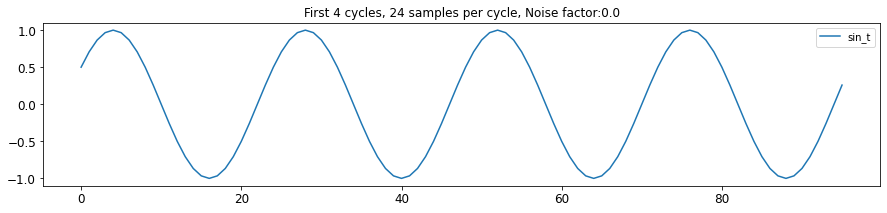

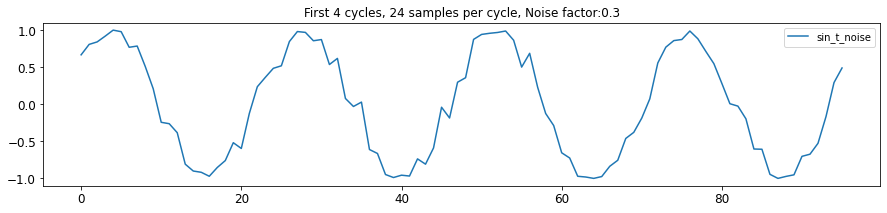

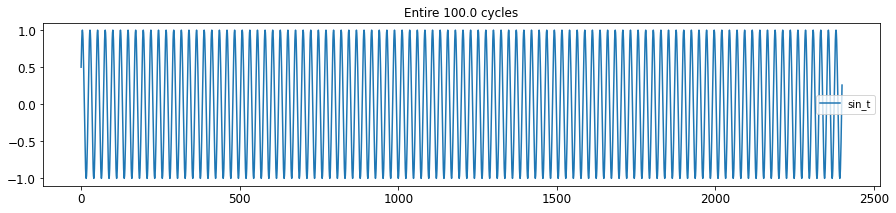

In [3]:
steps_per_cycle = 24
number_of_cycles = 100
noise_factor_src = [.0, .3]
n_plot = 4

df = noisy_sin(
      steps_per_cycle=steps_per_cycle,
      number_of_cycles=number_of_cycles,
      offset = 2,
      random_factor = noise_factor_src[0],
      name="sin_t")
fig = df[["sin_t"]].head(steps_per_cycle * n_plot).plot(
      title="First {0} cycles, {1} samples per cycle, Noise factor:{2}".format(
            n_plot, steps_per_cycle, noise_factor_src[0]),
      figsize=(15,3))
fig.figure.savefig(os.path.join(path_sess,str(idx_fig))+".svg", format='svg', dpi=1200)
idx_fig += 1



noise_factor = .3
df["sin_t_noise"] = noisy_sin(
      steps_per_cycle=steps_per_cycle,
      number_of_cycles=number_of_cycles,
      offset = 2,
      random_factor = noise_factor_src[1],
      name="sin_t_noise")["sin_t_noise"]
fig = df[["sin_t_noise"]].head(steps_per_cycle * n_plot).plot(
      title="First {0} cycles, {1} samples per cycle, Noise factor:{2}".format(
            n_plot, steps_per_cycle, noise_factor_src[1]),
      figsize=(15,3))
fig.figure.savefig(os.path.join(path_sess,str(idx_fig))+".svg", format='svg', dpi=1200)
idx_fig += 1


fig = df[["sin_t"]].plot(
      title="Entire {} cycles".format(len(df)/steps_per_cycle),
      figsize=(15,3))
fig.figure.savefig(os.path.join(path_sess,str(idx_fig))+".svg", format='svg', dpi=1200)
idx_fig += 1

In [4]:
def _load_data(data, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].to_numpy())
        docY.append(data.iloc[i+n_prev].to_numpy())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

length_of_sequences = 2
test_size = 0.25
ntr = int(len(df) * (1 - test_size))
df_train = df[["sin_t"]].iloc[:ntr]
df_test  = df[["sin_t"]].iloc[ntr:]
(X_train, y_train) = _load_data(df_train, n_prev = length_of_sequences)
(X_test, y_test)   = _load_data(df_test, n_prev = length_of_sequences)  
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

length_of_sequences = 2
test_size = 0.25
ntr = int(len(df) * (1 - test_size))
df_train_noise = df[["sin_t_noise"]].iloc[:ntr]
df_test_noise  = df[["sin_t_noise"]].iloc[ntr:]
(X_train_noise, y_train_noise) = _load_data(df_train_noise, n_prev = length_of_sequences)
(X_test_noise, y_test_noise)   = _load_data(df_test_noise, n_prev = length_of_sequences)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)



(1798, 2, 1) (1798, 1) (598, 2, 1) (598, 1)
(1798, 2, 1) (1798, 1) (598, 2, 1) (598, 1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 1)]            0         
                                                                 
 RNN (SimpleRNN)             (None, 2, 3)              15        
                                                                 
 RNN2 (SimpleRNN)            (None, 2, 3)              21        
                                                                 
 RNN3 (SimpleRNN)            (None, 3)                 21        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


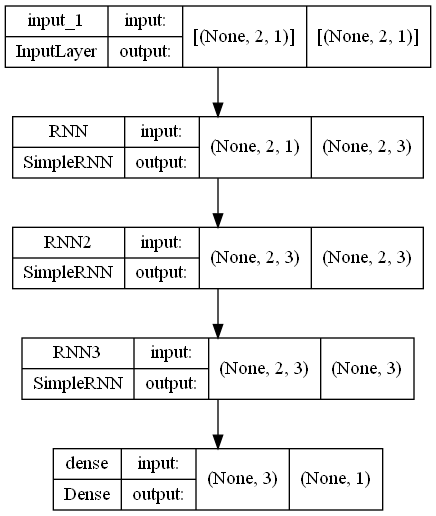

In [5]:
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense, Activation 
from keras.layers.recurrent import SimpleRNN
from tensorflow.keras.utils import plot_model


def define_model(length_of_sequences, batch_size = None, stateful = False):
    in_out_neurons = 1
    hidden_neurons = 3
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  

    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=True,
                    stateful=stateful,
                    name="RNN")(inp)
    
    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=True,
                    stateful = stateful,
                    name="RNN2")(rnn)

    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN3")(rnn) 

    dens = Dense(in_out_neurons,name="dense")(rnn)
    model = Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error", optimizer="rmsprop")

    
    return(model,(inp,rnn,dens))
## use the default values for batch_size, stateful
# 
model, (inp,rnn,dens) = define_model(length_of_sequences = X_train.shape[1])
model.summary()

plot_model(model, to_file=os.path.join(path_sess, "model.png"), show_shapes=True)

Epoch 1/1000
2/2 - 3s - loss: 0.1913 - val_loss: 0.1695 - 3s/epoch - 1s/step
Epoch 2/1000
2/2 - 0s - loss: 0.1681 - val_loss: 0.1553 - 68ms/epoch - 34ms/step
Epoch 3/1000
2/2 - 0s - loss: 0.1542 - val_loss: 0.1445 - 65ms/epoch - 32ms/step
Epoch 4/1000
2/2 - 0s - loss: 0.1436 - val_loss: 0.1357 - 61ms/epoch - 30ms/step
Epoch 5/1000
2/2 - 0s - loss: 0.1347 - val_loss: 0.1278 - 60ms/epoch - 30ms/step
Epoch 6/1000
2/2 - 0s - loss: 0.1271 - val_loss: 0.1213 - 62ms/epoch - 31ms/step
Epoch 7/1000
2/2 - 0s - loss: 0.1208 - val_loss: 0.1156 - 84ms/epoch - 42ms/step
Epoch 8/1000
2/2 - 0s - loss: 0.1150 - val_loss: 0.1101 - 114ms/epoch - 57ms/step
Epoch 9/1000
2/2 - 0s - loss: 0.1096 - val_loss: 0.1053 - 80ms/epoch - 40ms/step
Epoch 10/1000
2/2 - 0s - loss: 0.1049 - val_loss: 0.1012 - 62ms/epoch - 31ms/step
Epoch 11/1000
2/2 - 0s - loss: 0.1008 - val_loss: 0.0975 - 63ms/epoch - 32ms/step
Epoch 12/1000
2/2 - 0s - loss: 0.0972 - val_loss: 0.0942 - 61ms/epoch - 30ms/step
Epoch 13/1000
2/2 - 0s - los

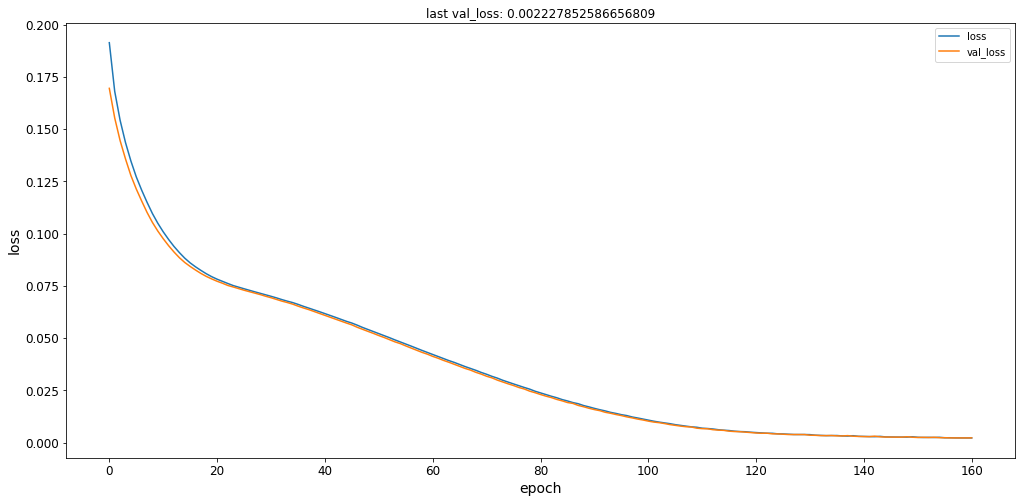

In [6]:
log_dir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

cb_tensorboard = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)

class CustomEarlyStopping(keras.callbacks.EarlyStopping):
    def __init__(self, ratio=.0,
                 patience=0, verbose=0):
        super(keras.callbacks.EarlyStopping, self).__init__()

        self.ratio = ratio
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.stopped_epoch = 0
        self.monitor_op = np.greater

    def on_train_begin(self, logs=None):
        self.wait = 0  # Allow instances to be re-used

    def on_epoch_end(self, epoch, logs=None):
        current_val = logs.get('val_loss')
        current_train = logs.get('loss')
        if current_val is None:
            warnings.warn('Early stopping requires %s available!' %
                          (self.monitor), RuntimeWarning)

        # If ratio current_loss / current_val_loss > self.ratio
        if self.monitor_op(np.divide(current_train,current_val),self.ratio):
            self.wait = 0
        else:
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
            self.wait += 1

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print('Epoch %05d: early stopping' % (self.stopped_epoch))

# cb_earlystopping = keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     mode='min',
#     baseline=10-6,
#     restore_best_weights=True,
#     patience=500,
#     verbose=1)

cb_earlystopping = CustomEarlyStopping(
    ratio=.999,
    patience=1,
    verbose=1)


fig = plt.figure(figsize=(17,8))

batch_size = 1000
epochs = 1000
hist = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_split=0.3,
    callbacks=[cb_tensorboard, cb_earlystopping])
ax1 = fig.add_subplot(111)
for label in ["loss","val_loss"]:
    ax1.plot(hist.history[label],label=label)
ax1.set_ylabel("loss")
ax1.set_xlabel("epoch")
ax1.set_title("batch_size:{0}, epoch:{1}".format(batch_size, epochs))
ax1.set_title("last val_loss: {}".format(hist.history["val_loss"][-1]))
ax1.legend()

fig.figure.savefig(os.path.join(path_sess,str(idx_fig))+".svg", format='svg', dpi=1200)
idx_fig += 1

In [7]:
%load_ext tensorboard
%tensorboard --logdir logs/scalars

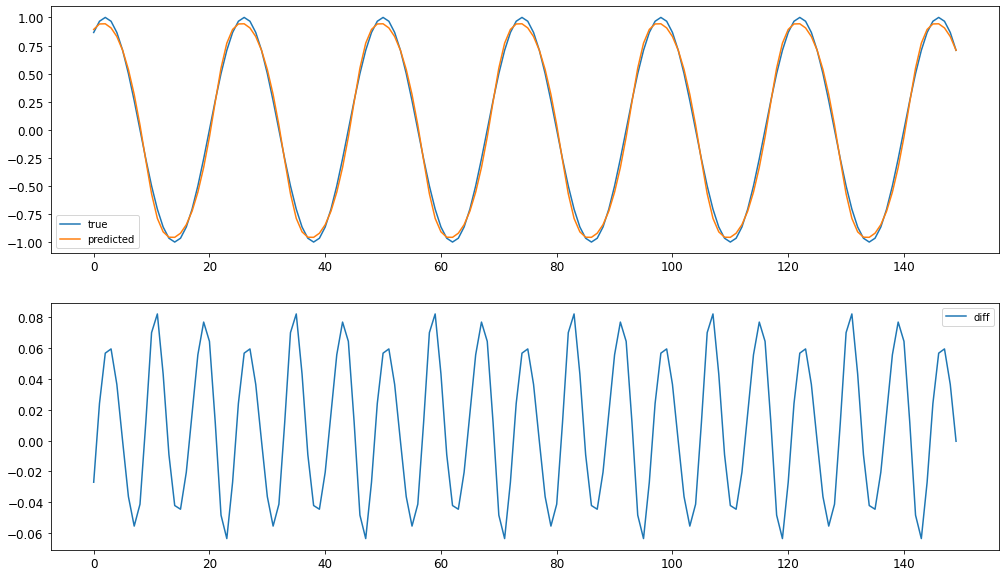

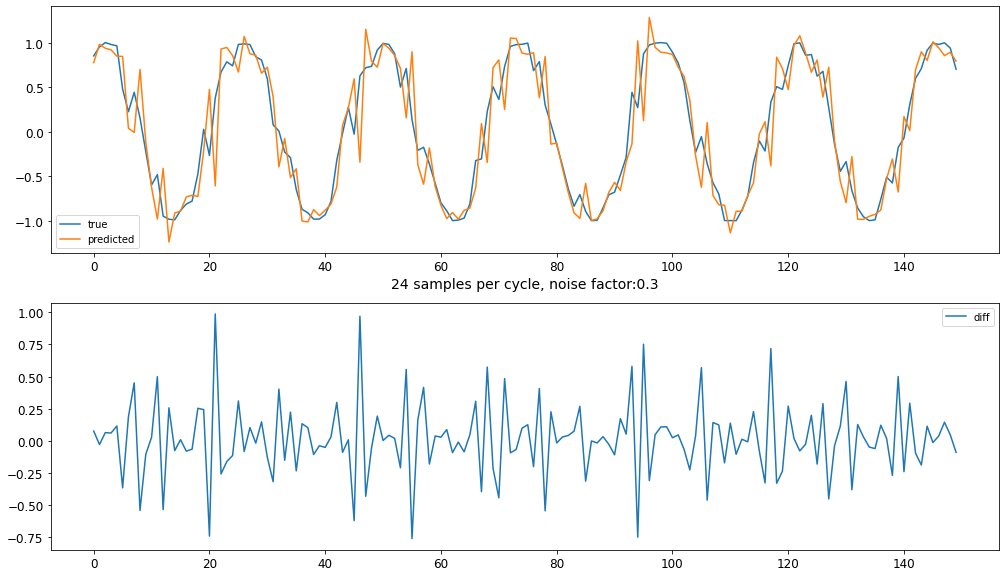

In [8]:
y_pred = model.predict(X_test)

n_plot = 150
fig = plt.figure(figsize=(17,10))
ax0 = fig.add_subplot(211)
ax0.plot(y_test[:n_plot],label="true")
ax0.plot(y_pred[:n_plot],label="predicted")
ax0.legend()

ax1 = fig.add_subplot(212)
ax1.plot((y_test[:n_plot]-y_pred[:n_plot]), label="diff")
ax1.legend()

fig.figure.savefig(os.path.join(path_sess,str(idx_fig))+".svg", format='svg', dpi=1200)
idx_fig += 1




y_pred_noise = model.predict(X_test_noise)

n_plot = 150
fig = plt.figure(figsize=(17,10))
ax0 = fig.add_subplot(211)
ax0.plot(y_test_noise[:n_plot],label="true")
ax0.plot(y_pred_noise[:n_plot],label="predicted")
ax0.set_xlabel("{0} samples per cycle, noise factor:{1}".format(steps_per_cycle, noise_factor_src[1]))
ax0.legend()

ax1 = fig.add_subplot(212)
ax1.plot((y_test_noise[:n_plot]-y_pred_noise[:n_plot]), label="diff")
ax1.legend()

fig.figure.savefig(os.path.join(path_sess,str(idx_fig))+".svg", format='svg', dpi=1200)
idx_fig += 1


In [9]:
ws = {}
for layer in model.layers:
    ws[layer.name] = layer.get_weights()
ws

{'input_1': [],
 'RNN': [array([[-0.5004338,  0.7596878,  0.5558791]], dtype=float32),
  array([[ 0.12471541,  0.42675242,  0.91741693],
         [-0.5044652 ,  0.45249492,  0.07467071],
         [-0.3724129 , -0.9150327 ,  0.3926644 ]], dtype=float32),
  array([-0.00073575, -0.0042861 , -0.00088711], dtype=float32)],
 'RNN2': [array([[ 0.54842067, -0.61513036, -0.33146843],
         [-0.1329259 , -0.8733522 ,  0.31767043],
         [-0.7418662 , -0.3012653 ,  0.23118718]], dtype=float32),
  array([[-0.3306051 , -0.8827671 , -0.2841686 ],
         [-0.7193092 , -0.08640337,  0.82588255],
         [ 0.46061975, -0.5181442 ,  0.44371578]], dtype=float32),
  array([ 0.00013818, -0.00690939, -0.0022325 ], dtype=float32)],
 'RNN3': [array([[ 0.11629786,  1.0060049 , -1.0252304 ],
         [ 1.054194  ,  0.2508254 ,  0.05380146],
         [-0.25796458, -0.25053477,  0.61390316]], dtype=float32),
  array([[ 0.22075963,  0.51916677,  0.753279  ],
         [ 0.25906134,  0.6216096 , -0.660792  

In [10]:
rnn_model = Model(inputs=[inp],outputs=[rnn])
rnn_model.compile(loss="mean_squared_error", optimizer="rmsprop")
hidden_units = rnn_model.predict(X_test).flatten()

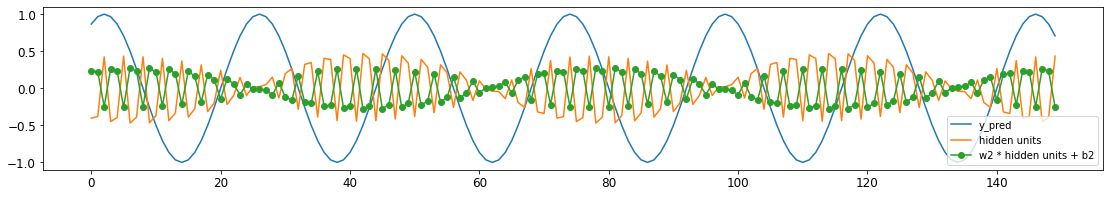

In [11]:
predicted_sin_wave = ws["dense"][0][0][0]*hidden_units + ws["dense"][1][0]

fig = plt.figure(figsize=(19,3))
plt.plot(y_test[:n_plot],label="y_pred")
plt.plot(hidden_units[:n_plot],label="hidden units")
plt.plot(predicted_sin_wave[:n_plot],"o-",
         label="w2 * hidden units + b2")
plt.legend()

fig.figure.savefig(os.path.join(path_sess,str(idx_fig))+".svg", format='svg', dpi=1200)
idx_fig += 1

In [12]:
steps_per_cycle = [15, 50, 120]
noise_factors = [.2, .1, .3]
df["x1"] = noisy_sin(
    steps_per_cycle=steps_per_cycle[0], 
    number_of_cycles=100, offset=3, 
    random_factor=noise_factors[0], name="x1")["x1"][:n_plot]
df["x2"] = noisy_sin(
    steps_per_cycle=steps_per_cycle[1], 
    number_of_cycles=100, offset=5, 
    random_factor=noise_factors[1], name="x2")["x2"][:n_plot]
df["x3"] = noisy_sin(
    steps_per_cycle=steps_per_cycle[2], 
    number_of_cycles=100, offset=7, 
    random_factor=noise_factors[2], name="x3")["x3"][:n_plot]

df["x1+x2"] = df["x1"]+df["x2"]
df["x1+x3"] = df["x1"]+df["x3"]
df["x2+x3"] = df["x2"]+df["x3"]
df["x1+x2+x3"] = df["x1"]+df["x2"]+df["x3"]

create period-15 sin wave with 100 cycles
In total, the sin wave time series length is 1501
create period-50 sin wave with 100 cycles
In total, the sin wave time series length is 5001
create period-120 sin wave with 100 cycles
In total, the sin wave time series length is 12001


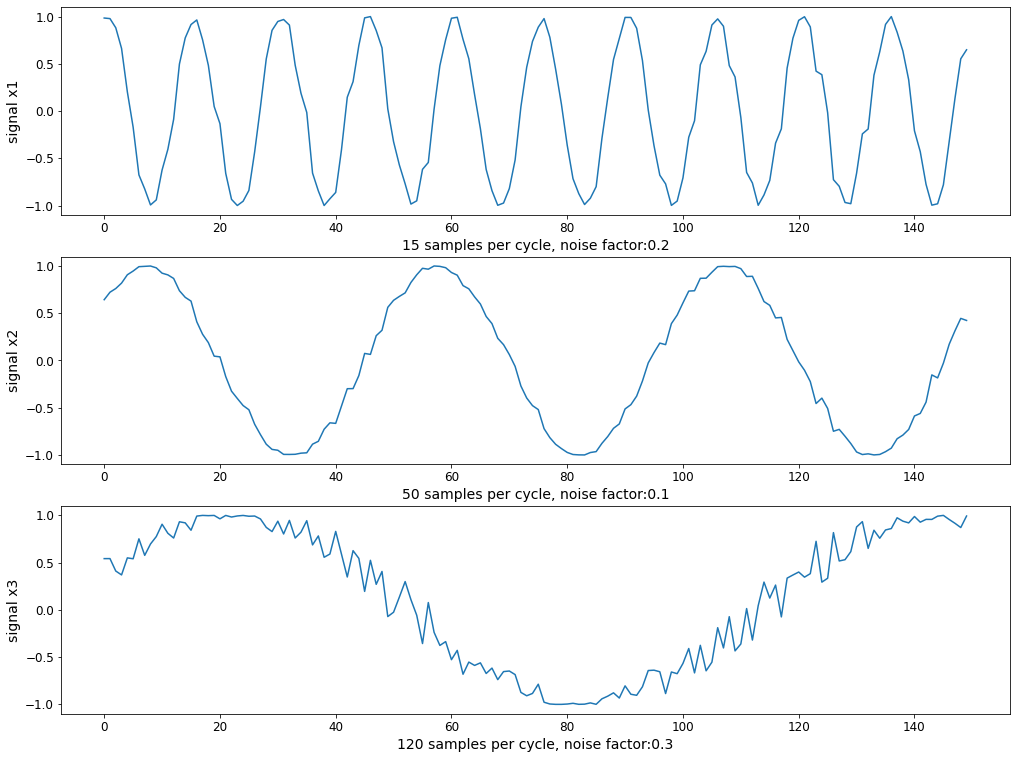

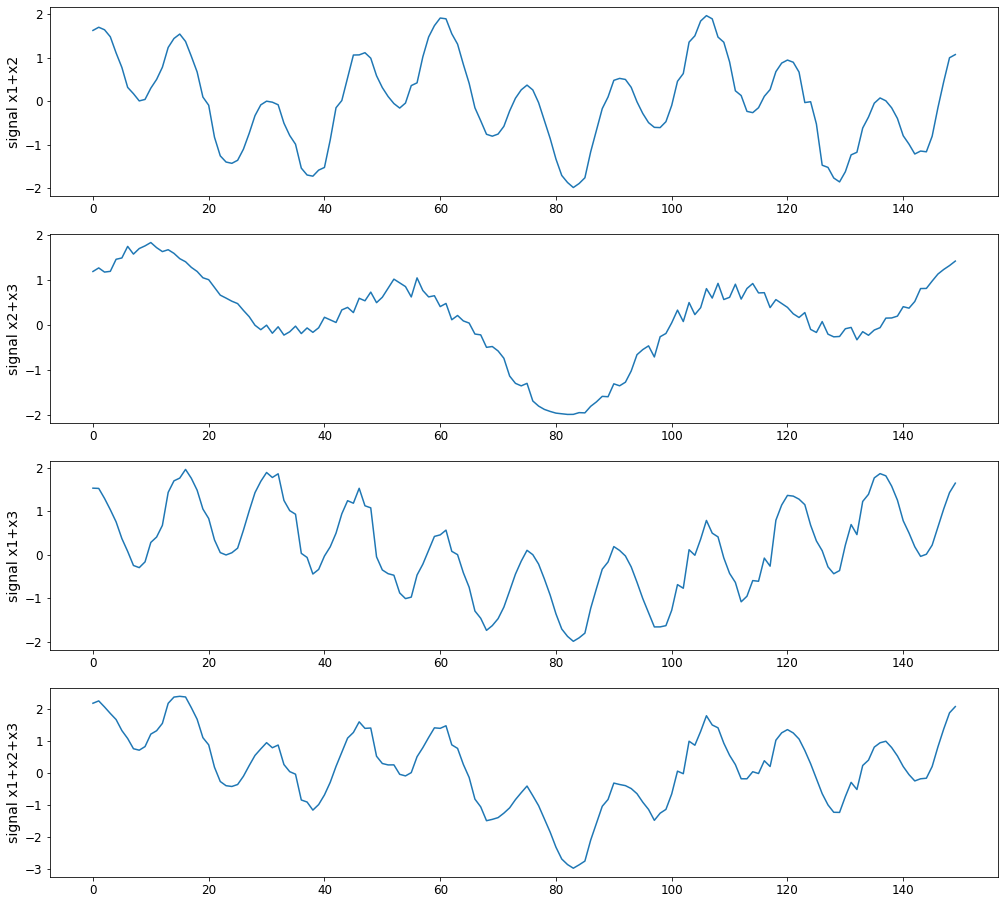

In [13]:
orig = ["x1", "x2", "x3"]
fig, axes = plt.subplots(3, 1, figsize=(17,13))

for i, ax in zip(range(len(orig)), axes):
    axes[i].plot(df[orig[i]].head(n_plot))
    axes[i].set_ylabel("signal {}".format(orig[i]))
    axes[i].set_xlabel("{} samples per cycle, noise factor:{}".format(steps_per_cycle[i], noise_factors[i]))
fig.figure.savefig(os.path.join(path_sess,str(idx_fig))+".svg", format='svg', dpi=1200)
idx_fig += 1

mixed = ["x1+x2", "x2+x3", "x1+x3", "x1+x2+x3"]
fig, axes = plt.subplots(4, 1, figsize=(17,16))

for i, ax in zip(range(len(mixed)), axes):
    axes[i].plot(df[mixed[i][:n_plot]])
    axes[i].set_ylabel("signal {}".format(mixed[i]))
fig.figure.savefig(os.path.join(path_sess,str(idx_fig))+".svg", format='svg', dpi=1200)
idx_fig += 1

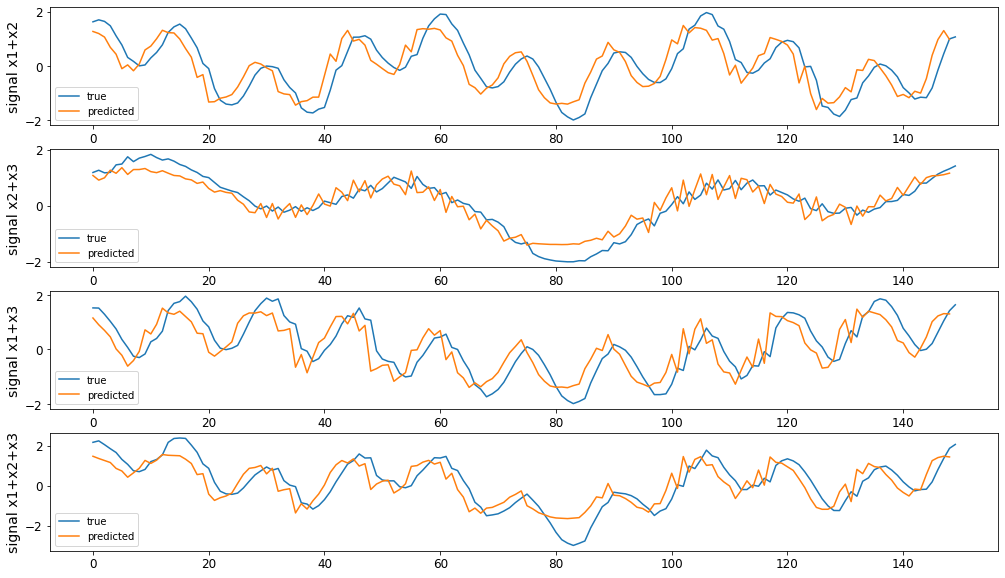

In [14]:
length_of_sequences = 2
st = []
for label in mixed:
    st.append(_load_data(df[[label]].iloc[:], n_prev = length_of_sequences)[0])


y_pred = []
for x in st:
    y_pred.append(model.predict(x))


fig = plt.figure(figsize=(17,10))

for i in range(len(mixed)):
    ax = fig.add_subplot(int(str(len(mixed))+"1"+str(i+1)))
    ax.plot(df[mixed[i]].iloc[:n_plot], label="true")
    ax.plot(y_pred[i][:n_plot], label="predicted")
    ax.set_ylabel("signal {}".format(mixed[i]))
    ax.legend()
    
fig.figure.savefig(os.path.join(path_sess,str(idx_fig))+".svg", format='svg', dpi=1200)
idx_fig += 1

In [15]:
# multivariate one step problem
from numpy import array
from numpy import hstack
from keras.preprocessing.sequence import TimeseriesGenerator
# define dataset
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95, 105])
# reshape series
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2))
print(dataset)
# define generator
n_input = 2
generator = TimeseriesGenerator(dataset, dataset, length=n_input, batch_size=1)
# number of samples
print('Samples: %d' % len(generator))
# print each sample
for i in range(len(generator)):
	x, y = generator[i]
	print('%s => %s' % (x, y))

[[ 10  15]
 [ 20  25]
 [ 30  35]
 [ 40  45]
 [ 50  55]
 [ 60  65]
 [ 70  75]
 [ 80  85]
 [ 90  95]
 [100 105]]
Samples: 8
[[[10 15]
  [20 25]]] => [[30 35]]
[[[20 25]
  [30 35]]] => [[40 45]]
[[[30 35]
  [40 45]]] => [[50 55]]
[[[40 45]
  [50 55]]] => [[60 65]]
[[[50 55]
  [60 65]]] => [[70 75]]
[[[60 65]
  [70 75]]] => [[80 85]]
[[[70 75]
  [80 85]]] => [[90 95]]
[[[80 85]
  [90 95]]] => [[100 105]]


In [16]:
import librosa


def load_wav(lst_file, block_size=2400, sr=48000, duration=60):
    # timestamp, start
    start_time = time.time()

    # listup files from given dir_wav
    n_files = len(lst_file)
    lst_size = [os.path.getsize(s) for s in lst_file]
    dct_file = {k: v for k, v in zip(lst_file, lst_size)}
    # lst_file = {k: v for k, v in sorted(lst_file.items(), key=lambda x: x[1])}
    lst_file = sorted(dct_file.items(), key=lambda x: x[1])
    
    wfs = np.empty((0, block_size), dtype=float)
    idx = 0
    _duration = 0
    _wfs = 0
    _offset = .5
    _duration = round(duration/n_files, 1)
    while(_wfs < duration):
        if(len(lst_file) == idx):
            idx = 0
            _offset += _duration
            pass

        if (len(lst_file) == 0):
            break

        else:
            pass

        try:
            wf, _ = librosa.load(
                lst_file[idx][0],
                sr=sr,
                mono=False,
                offset=_offset,
                duration=_duration,
                res_type='kaiser_best')
            
            print("\tloaded:{0}, {1:3.3f}s ~ {2:3.3f}s".format(
            os.path.basename(lst_file[idx][0]), _offset, _offset+(wf.shape[1]/sr)))

            # If it's stereo signal
            if(np.array(wf.shape)[0] == 2):
                wf = (wf[0, :] + wf[1, :]) / 2
                wf = (wf - wf.min()) / (wf.max() - wf.min()) + 1e-16
                pass
            else:
                wf = (wf - wf.min()) / (wf.max() - wf.min()) + 1e-16
                pass

            # sd.play(wf, sr)

            _len_read = round(wf.shape[0]/sr, 1)
            if(_len_read < int(_duration)):
                lst_file.pop(idx)
                pass
            else:
                idx += 1
                pass
            pass

            n_blocks = wf.shape[0]//block_size
            wf = wf[:n_blocks*block_size]

            wf = wf.reshape(wf.shape[0]//block_size, block_size)
            wfs = np.vstack((wfs, wf))
            _wfs += _len_read

        except Exception as e:
            print("\t", e, ": file, {}".format(lst_file[idx]))
            lst_file.pop(idx)
            # lst_file.remove(lst_file[j])
            pass

        pass
    _n_frame = int(sr/block_size*duration)
    if wfs.shape[0] > _n_frame:
        wfs = wfs[1:_n_frame+1, :]
        pass
    else:
        pass

    print("read in this class: %2.1f seconds" % (wfs.shape[0]*wfs.shape[1]/sr))

    end_time = time.time()
    print("took {0:.1f} seconds...\n".format(end_time-start_time))

    # return wfs_class, {"class_type":class_type, "len_total":len_total, "n_files":n_files, "power_wfs":np.power(wfs_in_dir, 2).mean()}
    return wfs

def one_hot(x, n, depth):
    y = np.squeeze(np.eye(depth)[x]).reshape(len(x),depth)
    return y


def get_dataset_partitions_tf(
    ds, ds_size, 
    train_split=0.6, 
    val_split=0.2, 
    test_split=0.2, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
        pass
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    x_train = ds.take(train_size)    
    x_val = ds.skip(train_size).take(val_size)
    x_test = ds.skip(train_size).skip(val_size)
    
    return x_train, x_val, x_test

In [17]:
import glob


path_source = r"c:\users\sinwooyoo\source\data\input\waves\background_noise"

print("Reading data list...")
lst_class = [s for s in os.listdir(path_source) if os.path.isdir(os.path.join(path_source,s))]
if len(lst_class)==0:
    lst_class = [path_source]
    pass

features = np.empty((0, int(2400)))
labels = np.empty((0,1))
labels_one_hot = np.empty((0, len(lst_class)))

for id_name in lst_class:
    paths_wav = glob.glob(os.path.join(path_source, id_name) + '\*.wav')
    
    feature = np.row_stack(load_wav(paths_wav, duration=10/len(lst_class)))
    label = np.repeat(lst_class.index(id_name), repeats=len(feature)).reshape(len(feature), 1)
    label_one_hot = one_hot(label, feature.shape[0], len(lst_class))

    features = np.row_stack((feature, features))
    labels = np.row_stack((label, labels))
    labels_one_hot = np.row_stack((label_one_hot, labels_one_hot))

    pass

dataset = tf.data.Dataset.from_tensor_slices((features, labels, labels_one_hot))
# save dataset as a tfrecord



# load the saved dataset
x_data, x_val, x_test = get_dataset_partitions_tf(dataset, features.shape[0])
x_data = x_data.repeat().shuffle(10000).batch(256)




Reading data list...
	loaded:1.wav, 0.500s ~ 1.200s
	loaded:2.wav, 0.500s ~ 1.200s
	loaded:3.wav, 0.500s ~ 1.200s
	loaded:4.wav, 0.500s ~ 1.200s
	loaded:5.wav, 0.500s ~ 1.200s
	loaded:6.wav, 0.500s ~ 1.200s
	loaded:7.wav, 0.500s ~ 1.200s
	loaded:bg-night-1-0021_LR.wav, 0.500s ~ 1.200s
	loaded:bg-0-0021_LR.wav, 0.500s ~ 1.200s
	loaded:216636__zabuhailo__park1.wav, 0.500s ~ 1.200s
	loaded:126757__sbordage__london-waterloo-park.wav, 0.500s ~ 1.200s
	loaded:9.wav, 0.500s ~ 1.200s
	loaded:8.wav, 0.500s ~ 1.200s
	loaded:425367__soundholder__ambient-open-bunker-wind-blows-and-road-noises-stereo-ortf-8040.wav, 0.500s ~ 1.200s
	loaded:10.wav, 0.500s ~ 1.200s
read in this class: 10.0 seconds
took 1.4 seconds...

